# [--- Day 14: Disk Defragmentation ---](http://adventofcode.com/2017/day/14)

Suddenly, a scheduled job activates the system's disk defragmenter. Were the situation different, you might sit and watch it for a while, but today, you just don't have that kind of time. It's soaking up valuable system resources that are needed elsewhere, and so the only option is to help it finish its task as soon as possible.

The disk in question consists of a 128x128 grid; each square of the grid is either free or used. On this disk, the state of the grid is tracked by the bits in a sequence of knot hashes.

A total of 128 knot hashes are calculated, each corresponding to a single row in the grid; each hash contains 128 bits which correspond to individual grid squares. Each bit of a hash indicates whether that square is free (0) or used (1).

The hash inputs are a key string (your puzzle input), a dash, and a number from 0 to 127 corresponding to the row. For example, if your key string were flqrgnkx, then the first row would be given by the bits of the knot hash of flqrgnkx-0, the second row from the bits of the knot hash of flqrgnkx-1, and so on until the last row, flqrgnkx-127.

The output of a knot hash is traditionally represented by 32 hexadecimal digits; each of these digits correspond to 4 bits, for a total of 4 * 32 = 128 bits. To convert to bits, turn each hexadecimal digit to its equivalent binary value, high-bit first: 0 becomes 0000, 1 becomes 0001, e becomes 1110, f becomes 1111, and so on; a hash that begins with a0c2017... in hexadecimal would begin with 10100000110000100000000101110000... in binary.

Continuing this process, the first 8 rows and columns for key flqrgnkx appear as follows, using # to denote used squares, and . to denote free ones:

```
##.#.#..-->
.#.#.#.#   
....#.#.   
#.#.##.#   
.##.#...   
##..#..#   
.#...#..   
##.#.##.-->
|      |   
V      V   
```

In this example, 8108 squares are used across the entire 128x128 grid.

**Given your actual key string, how many squares are used?**

Your puzzle input is `ugkiagan`.

First up, since we need to make 128 knot hashes from the puzzle input:

In [173]:
puzzle_input = ["ugkiagan-" + str(i) for i in range(128)]
puzzle_input[:5], puzzle_input[-4:]

(['ugkiagan-0', 'ugkiagan-1', 'ugkiagan-2', 'ugkiagan-3', 'ugkiagan-4'],
 ['ugkiagan-124', 'ugkiagan-125', 'ugkiagan-126', 'ugkiagan-127'])

Now to actually knot dem hashes, so putting my somewhat messy code [from day 10](https://github.com/khalido/advent2017/blob/master/Day%2010%20-%20Knot%20Hash.ipynb) into one function:

In [69]:
from functools import reduce
import operator
import numpy as np

def knot_hash(key):
    """takes in a key and returns the hash """
    suffix = [int(i) for i in "17,31,73,47,23".split(",")]
    key_bytes = [ord(c) for c in key] + suffix

    string = [i for i in range(256)]

    skip_size = 0
    cur_pos = 0
    
    def make_substring_and_reverse(start_idx, length):
        """makes substring, reverses it, then returns full string"""
        if length > len(string):
            print("too long!")

        end_idx = start_idx + length
        if end_idx < len(string):
            return string[:start_idx] + string[start_idx:end_idx][::-1] + string[end_idx:]
        else:
            firstbit = string[start_idx:]

            wrap_pos = end_idx % len(string)
            secondbit = string[:(length-len(firstbit))]

            reverseString = (firstbit+secondbit)[::-1]

            # now to update the actual string
            temp_pos = cur_pos

            for char in reverseString:
                if temp_pos >= len(string):
                    temp_pos = 0
                string[temp_pos] = char
                temp_pos += 1

            return string
    
    for _ in range(64):
        for num in key_bytes:
            string = make_substring_and_reverse(cur_pos, num)
            # make cur_pos circular
            cur_pos += (num + skip_size)
            if cur_pos > len(string):
                cur_pos = cur_pos % len(string)
            skip_size += 1
    
    hash = []
    for i in range(0,256,16):
        h = reduce(operator.xor, string[i:i+16])
        hash.append(h)
    
    final_hash = [f"{c:02x}" for c in hash]
    final_hash = "".join(final_hash)
    return final_hash
    
    
assert knot_hash("") == "a2582a3a0e66e6e86e3812dcb672a272"
assert knot_hash("AoC 2017") == "33efeb34ea91902bb2f59c9920caa6cd"
assert knot_hash("1,2,3") == "3efbe78a8d82f29979031a4aa0b16a9d"
assert knot_hash("1,2,4") == "63960835bcdc130f0b66d7ff4f6a5a8e"
assert knot_hash("129,154,49,198,200,133,97,254,41,6,2,1,255,0,191,108") == "62e2204d2ca4f4924f6e7a80f1288786"

In [164]:
def binary_hash(key):
    return bin(int(knot_hash(key), 16))

binary_hash("ugkiagan-0")

'0b111111101000100111011010101111010111111111110110100111111111010110111100101110000110110100011001111010001011010111001010000101'

now to test this:

In [89]:
test_input = ["flqrgnkx-" + str(i) for i in range(128)]
test_input[:5], puzzle_input[-4:]

(['flqrgnkx-0', 'flqrgnkx-1', 'flqrgnkx-2', 'flqrgnkx-3', 'flqrgnkx-4'],
 ['ugkiagan-124', 'ugkiagan-125', 'ugkiagan-126', 'ugkiagan-127'])

I'm just counting the ones in the simplest possible manner, though there has to be a much faster numpy way of doing this:

In [169]:
def squares_used(key_string):
    grid = [binary_hash(k) for k in key_string]
    used = 0
    for h in grid:
        used += h.count("1")
    return used

print(squares_used(test_input))
squares_used(puzzle_input)

8108


8292

# --- Part Two ---

Now, all the defragmenter needs to know is the number of regions. A region is a group of used squares that are all adjacent, not including diagonals. Every used square is in exactly one region: lone used squares form their own isolated regions, while several adjacent squares all count as a single region.

In the example above, the following nine regions are visible, each marked with a distinct digit:

```
11.2.3..-->
.1.2.3.4   
....5.6.   
7.8.55.9   
.88.5...   
88..5..8   
.8...8..   
88.8.88.-->
|      |   
V      V   
```

Of particular interest is the region marked 8; while it does not appear contiguous in this small view, all of the squares marked 8 are connected when considering the whole 128x128 grid. In total, in this example, 1242 regions are present.

**How many regions are present given your key string?**

In [174]:
# the viz stuff
%matplotlib inline
import matplotlib.pyplot as plt # mpl is the base of all python plotting angst
import seaborn as sns # put some trainer wheels & lipstick on mpl

def visualize_squares_used(key_string):
    grid = [[int(i) for i in binary_hash(k)[2:]] for k in key_string]
    return grid

disk = visualize_squares_used(puzzle_input)
disk[0][:16]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]

In [175]:
len(disk),len(disk[0])

(128, 126)

So that gives us the disk, now to visualize it:

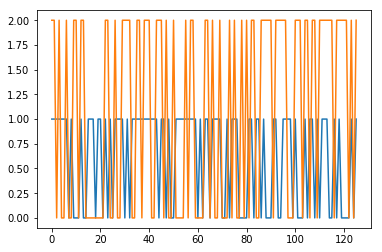

In [180]:
#plt.imshow(disk, cmap='hot', interpolation='nearest')
plt.plot(disk[0])
plt.plot(2*np.array(disk[1]), )

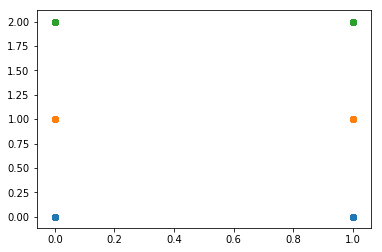

In [184]:
def plot_array(disk):
    for i, row in enumerate(disk):
        plt.scatter(row, [i for _ in range(len(disk[i]))])

plot_array(disk[:3])

In [187]:
np.arange(1,step=0)

ZeroDivisionError: division by zero